<a href="https://colab.research.google.com/github/SkyHonor/Research-on-Deep-Learning-Algorithms/blob/main/one-shot-learning/seamese-net/ContrastiveLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import torch
from PIL import Image, ImageFile

!wget http://usrbb.ru/botainika/Pepper.zip
!unzip Pepper.zip

data_path = datasets.ImageFolder(root="Pepper")

class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

transformation = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor()
                                    ])

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=data_path,
                                        transform=transformation)

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=16)

--2024-06-08 08:46:19--  http://usrbb.ru/botainika/Pepper.zip
Resolving usrbb.ru (usrbb.ru)... 213.141.129.202
Connecting to usrbb.ru (usrbb.ru)|213.141.129.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21077184 (20M) [application/zip]
Saving to: ‘Pepper.zip’

Pepper.zip          100%[===================>]  20.10M  1.88MB/s    in 11s     

2024-06-08 08:46:31 (1.78 MB/s) - ‘Pepper.zip’ saved [21077184/21077184]

Archive:  Pepper.zip
   creating: Pepper/
   creating: Pepper/Aphid/
  inflating: Pepper/Aphid/10.jpg     
  inflating: Pepper/Aphid/11.jpg     
  inflating: Pepper/Aphid/12.jpg     
  inflating: Pepper/Aphid/17.jpg     
  inflating: Pepper/Aphid/2.jpg      
  inflating: Pepper/Aphid/23.jpg     
  inflating: Pepper/Aphid/3.jpg      
  inflating: Pepper/Aphid/6.jpg      
  inflating: Pepper/Aphid/9.jpg      
  inflating: Pepper/Aphid/a1.jpg     
  inflating: Pepper/Aphid/a13.jpg    
  inflating: Pepper/Aphid/a15.jpg    
  inflating: Pepper/Aphid/a1

In [2]:
from torchvision import models
import torch.nn as nn

class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = models.resnet50(pretrained=True)

        self.cnn1.fc = nn.Sequential(
            nn.Linear(self.cnn1.fc.in_features, 2024),
            nn.ReLU(inplace=True),

            nn.Linear(2024, 1280)

        )

    def forward(self, x):
        output = self.cnn1.conv1(x)
        output = self.cnn1.bn1(output)
        output = self.cnn1.relu(output)
        output = self.cnn1.maxpool(output)
        output = self.cnn1.layer1(output)
        output = self.cnn1.layer2(output)
        output = self.cnn1.layer3(output)
        output = self.cnn1.layer4(output)
        output = self.cnn1.avgpool(output)
        output = torch.flatten(output, 1)
        output = self.cnn1.fc(output)
        return output

In [3]:
import torch.nn.functional as F

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [4]:
from torch import optim

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001 )


counter = []
loss_history = []
iteration_number= 0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.3MB/s]


Epoch number 0
 Current loss 5.522284507751465

Epoch number 0
 Current loss 1.182408094406128

Epoch number 1
 Current loss 0.8526548147201538

Epoch number 1
 Current loss 1.108970046043396

Epoch number 2
 Current loss 0.7176628112792969

Epoch number 2
 Current loss 0.7624785900115967

Epoch number 3
 Current loss 0.9180172085762024

Epoch number 3
 Current loss 0.7874391078948975

Epoch number 4
 Current loss 0.493718683719635

Epoch number 4
 Current loss 0.6518504619598389

Epoch number 5
 Current loss 0.5298689603805542

Epoch number 5
 Current loss 0.42368465662002563

Epoch number 6
 Current loss 0.6236592531204224

Epoch number 6
 Current loss 0.32679271697998047

Epoch number 7
 Current loss 0.4875069856643677

Epoch number 7
 Current loss 0.5372291803359985

Epoch number 8
 Current loss 0.5186851620674133

Epoch number 8
 Current loss 0.33458179235458374

Epoch number 9
 Current loss 0.26076745986938477

Epoch number 9
 Current loss 0.4661821722984314

Epoch number 10
 Cur

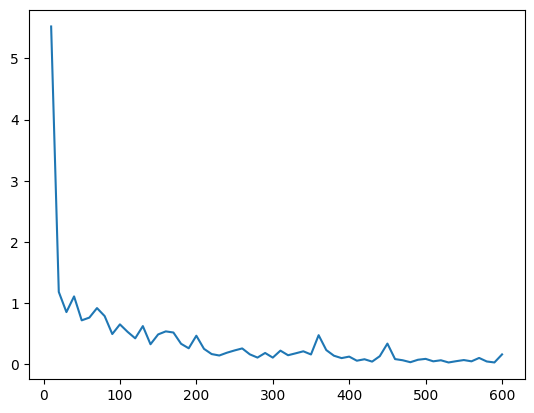

In [5]:
import matplotlib.pyplot as plt
for epoch in range(30):

    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()

        output1 = net.forward(img0)

        output2 = net.forward(img1)

        loss_contrastive = criterion(output1, output2, label)

        loss_contrastive.backward()

        optimizer.step()

        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

plt.plot(counter, loss_history)

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_path, test_size=0.2, random_state=0)

train_data_size = len(train)
test_data_size = len(test)

batch_size=8
train_data_loader = DataLoader(train, batch_size=batch_size)
test_data_loader = DataLoader(test, batch_size=batch_size)

In [7]:
transfer_model = net
print('model copied')

for param in transfer_model.parameters():
    param.requires_grad = False
print('weights are frozen')

transfer_model.cnn1.fc = nn.Sequential(
    nn.Linear(transfer_model.cnn1.fc[0].in_features,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,10)
    )

model copied
weights are frozen


In [8]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(transfer_model.parameters())

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None
    model = model.to(device)

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/test_data_size
        avg_valid_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        #torch.save(model, '_model_'+str(epoch)+'.pt')

    return model, history, best_epoch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 20
trained_model, history, best_epoch = train_and_validate(transfer_model, loss_func, optimizer, num_epochs)

#torch.save(history, '_history.pt')
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [ ]:
import torch
from torchvision import datasets, transforms

dataloader = train_dataloader
classes = data_path.classes

# Функция для извлечения признаков
def extract_features(model, dataloader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.cuda()
            features = model(images)
            all_features.append(features.cpu())
            all_labels.append(labels)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels

features, labels = extract_features(net, dataloader)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('logs/pepper')

In [ ]:
class_labels = [classes[lab] for lab in labels]

# log embeddings
writer.add_embedding(features,
                    metadata=class_labels,
                    global_step=0)
writer.close()

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs